In [1]:
import os
os.environ['SPARK_HOME'] = '/mnt/c/spark'
print(os.environ.get('SPARK_HOME'))

/mnt/c/spark


In [2]:
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pyspark.sql.functions import col, regexp_replace

In [4]:
spark = SparkSession.builder.appName('Preprocessing').getOrCreate()

FileNotFoundError: [WinError 2] Nie można odnaleźć określonego pliku

In [98]:
df = spark.read.csv("raw_datasets/train.csv", sep = ',', header=True)
print(f"Size of dataset: {df.count()}")
df = df.dropna()
print(f"Size of dataset: {df.count()}")

df = df.withColumn("model_year", col("model_year").cast(IntegerType())) \
               .withColumn("milage", col("milage").cast(DoubleType())) \
                .withColumn("price", col("price").cast(IntegerType()))

Size of dataset: 188533


[Stage 877:>                                                        (0 + 1) / 1]

Size of dataset: 162610


### Detecting and removing outliers

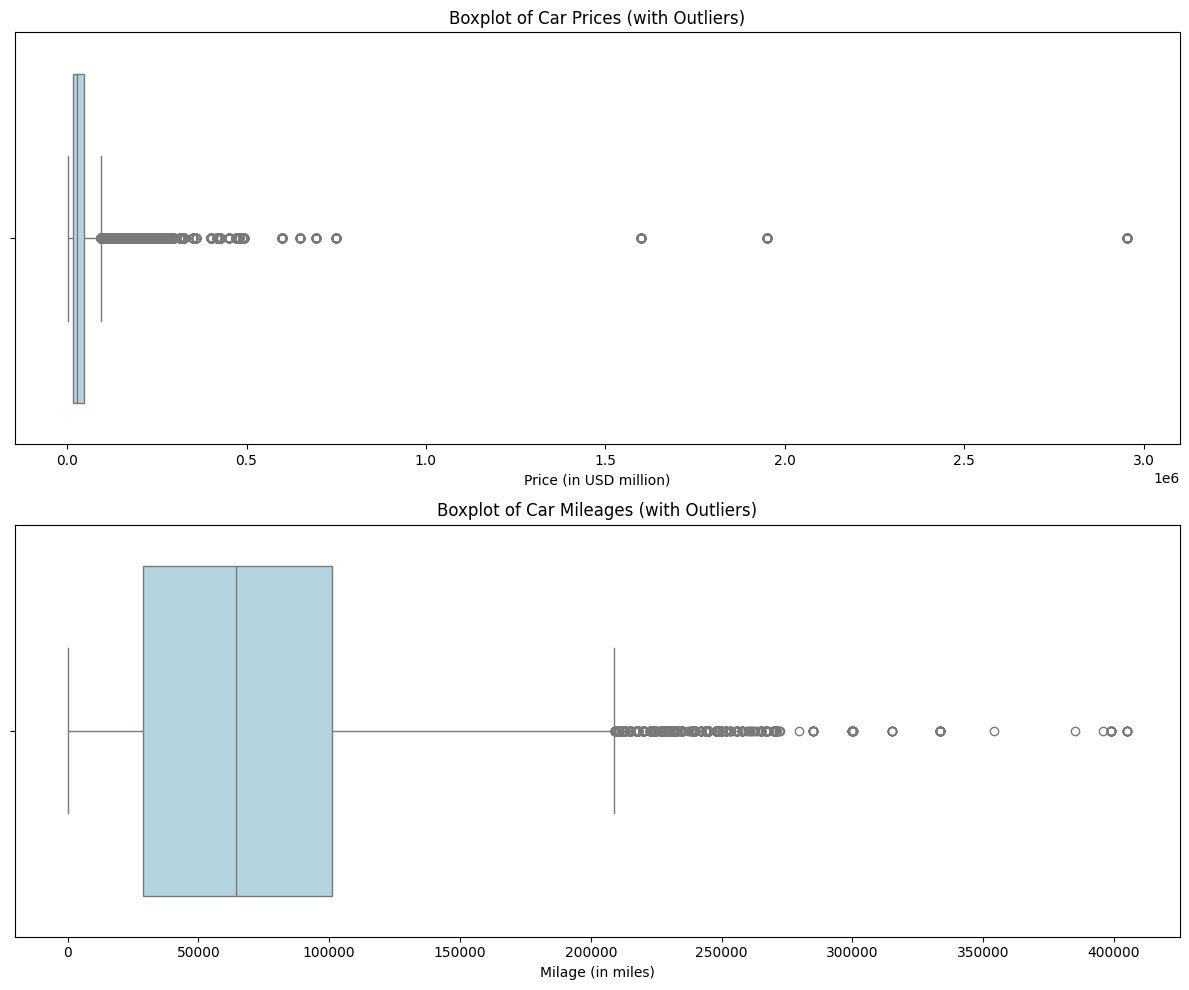

In [99]:
df_price = df.select("price").toPandas()
df_milage = df.select("milage").toPandas()

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot for 'price' in the first subplot
sns.boxplot(x=df_price["price"], color='lightblue', ax=axes[0])
axes[0].set_xlabel('Price (in USD million)')
axes[0].set_title('Boxplot of Car Prices (with Outliers)')

# Plot for 'milage' in the second subplot
sns.boxplot(x=df_milage["milage"], color='lightblue', ax=axes[1])
axes[1].set_xlabel('Milage (in miles)')
axes[1].set_title('Boxplot of Car Mileages (with Outliers)')

# Adjust spacing between subplots
plt.tight_layout()

# Save the combined figure
plt.savefig("charts/boxplots_with_outlires.png", bbox_inches="tight")

# Show the figure
plt.show()

In [100]:
# Detect outliers based on 'price' and 'milage'
q1_price, q3_price = df.approxQuantile("price", [0.25, 0.75], 0.05)
q1_milage, q3_milage = df.approxQuantile("milage", [0.25, 0.75], 0.05)

iqr_price = q3_price - q1_price
iqr_milage = q3_milage - q1_milage

# Define bounds for each column
lower_bound_price = q1_price - 1.5 * iqr_price
upper_bound_price = q3_price + 1.5 * iqr_price

lower_bound_milage = q1_milage - 1.5 * iqr_milage
upper_bound_milage = q3_milage + 1.5 * iqr_milage

# Filter out rows where either 'price' or 'milage' are outliers
filtered_df_multi = df.filter(
    (df["price"] >= lower_bound_price) & (df["price"] <= upper_bound_price) &
    (df["milage"] >= lower_bound_milage) & (df["milage"] <= upper_bound_milage)
)
df = filtered_df_multi
print(f"Size of dataset: {df.count()}")

Size of dataset: 147857


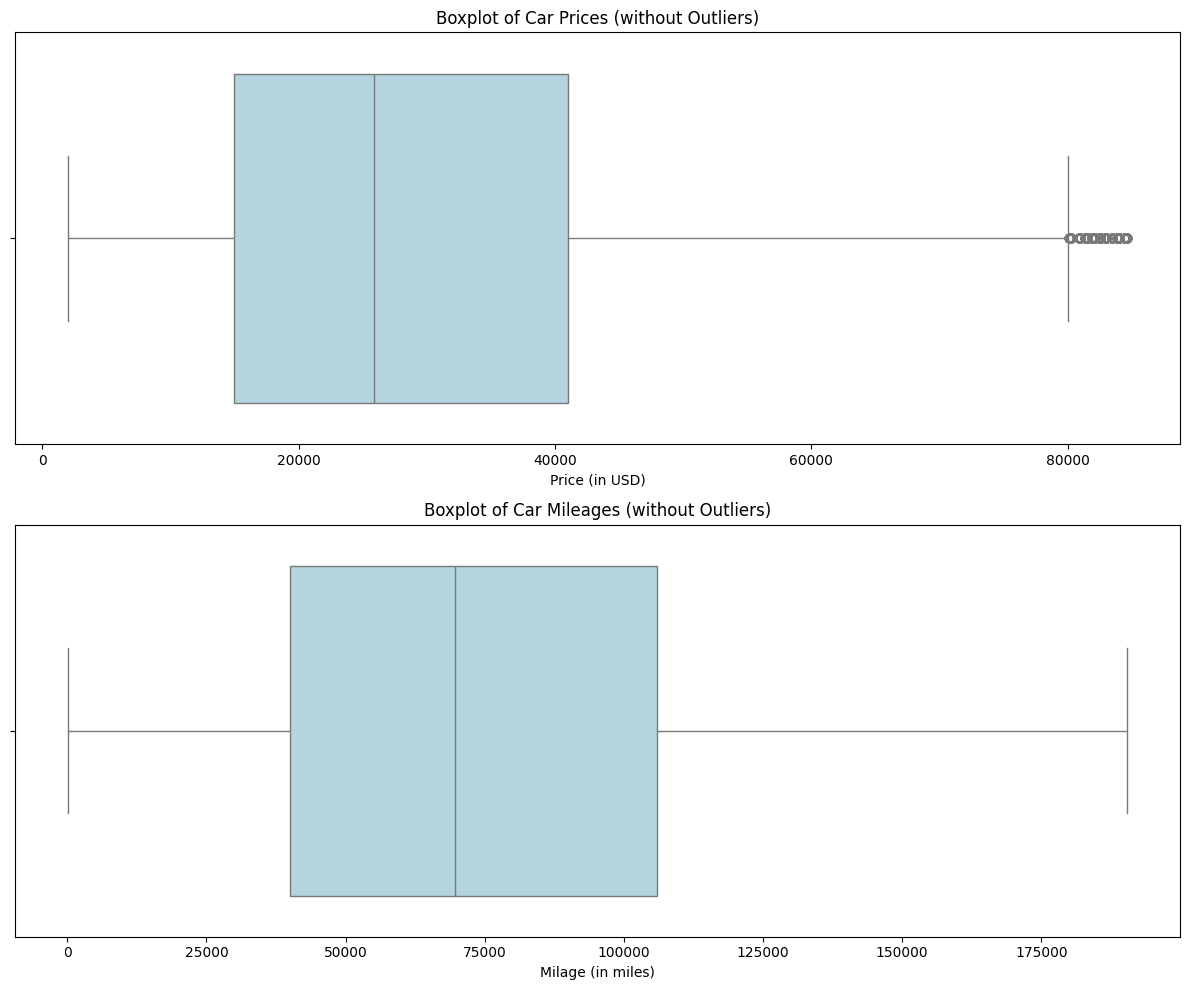

In [115]:
df_price = df.select("price").toPandas()
df_milage = df.select("milage").toPandas()

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot for 'price' in the first subplot
sns.boxplot(x=df_price["price"], color='lightblue', ax=axes[0])
axes[0].set_xlabel('Price (in USD)')
axes[0].set_title('Boxplot of Car Prices (without Outliers)')

# Plot for 'milage' in the second subplot
sns.boxplot(x=df_milage["milage"], color='lightblue', ax=axes[1])
axes[1].set_xlabel('Milage (in miles)')
axes[1].set_title('Boxplot of Car Mileages (without Outliers)')

# Adjust spacing between subplots
plt.tight_layout()

# Save the combined figure
plt.savefig("charts/boxplots_without_outlires.png", bbox_inches="tight")

# Show the figure
plt.show()

In [102]:
df.show(5)

+---+---------+-----------------+----------+--------+-------------+--------------------+--------------------+-------+-------+--------------------+-----------+-----+
| id|    brand|            model|model_year|  milage|    fuel_type|              engine|        transmission|ext_col|int_col|            accident|clean_title|price|
+---+---------+-----------------+----------+--------+-------------+--------------------+--------------------+-------+-------+--------------------+-----------+-----+
|  1|  Lincoln|            LS V8|      2002|143250.0|     Gasoline|252.0HP 3.9L 8 Cy...|                 A/T| Silver|  Beige|At least 1 accide...|        Yes| 4999|
|  2|Chevrolet|Silverado 2500 LT|      2002|136731.0|E85 Flex Fuel|320.0HP 5.3L 8 Cy...|                 A/T|   Blue|   Gray|       None reported|        Yes|13900|
|  3|  Genesis| G90 5.0 Ultimate|      2017| 19500.0|     Gasoline|420.0HP 5.0L 8 Cy...|Transmission w/Du...|  Black|  Black|       None reported|        Yes|45000|
|  5|     

In [103]:
column_names = df.columns
print(column_names)

for column_name in column_names:
    df_brand = df.select(column_name)
    print(f"distinct values in {column_name}: {df_brand.distinct().count()}")

['id', 'brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title', 'price']


distinct values in id: 147857


distinct values in brand: 57


distinct values in model: 1879


distinct values in model_year: 34


distinct values in milage: 5453


distinct values in fuel_type: 7


distinct values in engine: 1096


distinct values in transmission: 52


distinct values in ext_col: 307


distinct values in int_col: 154


distinct values in accident: 2


distinct values in clean_title: 1


[Stage 962:>                                                        (0 + 1) / 1]

distinct values in price: 1277


In [104]:
df = df.drop("model")

pattern_engine_capacity = r"(\d+\.\d+)L"
patter_horsepower = r"(\d+\.\d+)HP"

# Extract the number before 'L'
df_extracted_capacity = df.withColumn("engine_capacity", F.regexp_extract("engine", pattern_engine_capacity, 1))
df_extracted_horsepower = df_extracted_capacity.withColumn("engine_horsepower", F.regexp_extract("engine", patter_horsepower, 1))
# Show the result
df_extracted_horsepower = df_extracted_horsepower.drop("engine")
df_extracted_horsepower.show(truncate=False)

+---+-------------+----------+--------+-------------+------------------------------+------------------------------+-------+--------------------------------------+-----------+-----+---------------+-----------------+
|id |brand        |model_year|milage  |fuel_type    |transmission                  |ext_col                       |int_col|accident                              |clean_title|price|engine_capacity|engine_horsepower|
+---+-------------+----------+--------+-------------+------------------------------+------------------------------+-------+--------------------------------------+-----------+-----+---------------+-----------------+
|1  |Lincoln      |2002      |143250.0|Gasoline     |A/T                           |Silver                        |Beige  |At least 1 accident or damage reported|Yes        |4999 |3.9            |252.0            |
|2  |Chevrolet    |2002      |136731.0|E85 Flex Fuel|A/T                           |Blue                          |Gray   |None reported    

In [105]:
print(df_extracted_horsepower.count())
df_filtered = df_extracted_horsepower.filter(col("engine_capacity") != "")
print(f"without empty engine capacity rows {df_filtered.count()}")
df_filtered = df_filtered.filter(col("engine_horsepower") != "")
print(f"without empty engine horsepower rows {df_filtered.count()}")
df_filtered.show()

147857


without empty engine capacity rows 146299


[Stage 975:>                                                        (0 + 1) / 1]

without empty engine horsepower rows 135622
+---+-------------+----------+--------+-------------+--------------------+-------+-------+--------------------+-----------+-----+---------------+-----------------+
| id|        brand|model_year|  milage|    fuel_type|        transmission|ext_col|int_col|            accident|clean_title|price|engine_capacity|engine_horsepower|
+---+-------------+----------+--------+-------------+--------------------+-------+-------+--------------------+-----------+-----+---------------+-----------------+
|  1|      Lincoln|      2002|143250.0|     Gasoline|                 A/T| Silver|  Beige|At least 1 accide...|        Yes| 4999|            3.9|            252.0|
|  2|    Chevrolet|      2002|136731.0|E85 Flex Fuel|                 A/T|   Blue|   Gray|       None reported|        Yes|13900|            5.3|            320.0|
|  3|      Genesis|      2017| 19500.0|     Gasoline|Transmission w/Du...|  Black|  Black|       None reported|        Yes|45000|       

In [106]:
df_replaced = df_filtered.withColumn(
    "transmission",
    F.when(F.lower(F.col("transmission")).rlike("a/t|automatic"),"Automatic")
    .when(F.lower(F.col("transmission")).rlike("m/t|manual"),"Manual")
    .when(F.lower(F.col("transmission")).rlike("cvt|variator"),"Variator")
    .when(F.lower(F.col("transmission")).rlike("tiptronic"),"Tiptronic")
    .otherwise("Other")
)
df_replaced.show()


+---+-------------+----------+--------+-------------+------------+-------+-------+--------------------+-----------+-----+---------------+-----------------+
| id|        brand|model_year|  milage|    fuel_type|transmission|ext_col|int_col|            accident|clean_title|price|engine_capacity|engine_horsepower|
+---+-------------+----------+--------+-------------+------------+-------+-------+--------------------+-----------+-----+---------------+-----------------+
|  1|      Lincoln|      2002|143250.0|     Gasoline|   Automatic| Silver|  Beige|At least 1 accide...|        Yes| 4999|            3.9|            252.0|
|  2|    Chevrolet|      2002|136731.0|E85 Flex Fuel|   Automatic|   Blue|   Gray|       None reported|        Yes|13900|            5.3|            320.0|
|  3|      Genesis|      2017| 19500.0|     Gasoline|       Other|  Black|  Black|       None reported|        Yes|45000|            5.0|            420.0|
|  5|         Audi|      2018| 40950.0|     Gasoline|   Automati

In [107]:
column_names = df_replaced.columns
print(column_names)

for column_name in column_names:
    df_brand = df_replaced.select(column_name)
    print(f"distinct values in {column_name}: {df_brand.distinct().count()}")

['id', 'brand', 'model_year', 'milage', 'fuel_type', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title', 'price', 'engine_capacity', 'engine_horsepower']


distinct values in id: 135622


distinct values in brand: 56


distinct values in model_year: 33


distinct values in milage: 4919


distinct values in fuel_type: 7


distinct values in transmission: 4


distinct values in ext_col: 64


distinct values in int_col: 68


distinct values in accident: 2


distinct values in clean_title: 1


distinct values in price: 1219


distinct values in engine_capacity: 59


[Stage 1052:>                                                       (0 + 1) / 1]

distinct values in engine_horsepower: 333


In [108]:
df = df_replaced.drop("clean_title")
df = df.drop("id")
df.toPandas().to_csv("preprocessed_datasets/clean_data.csv",header=True,index=False)
df.show()

+-------------+----------+--------+-------------+------------+-------+-------+--------------------+-----+---------------+-----------------+
|        brand|model_year|  milage|    fuel_type|transmission|ext_col|int_col|            accident|price|engine_capacity|engine_horsepower|
+-------------+----------+--------+-------------+------------+-------+-------+--------------------+-----+---------------+-----------------+
|      Lincoln|      2002|143250.0|     Gasoline|   Automatic| Silver|  Beige|At least 1 accide...| 4999|            3.9|            252.0|
|    Chevrolet|      2002|136731.0|E85 Flex Fuel|   Automatic|   Blue|   Gray|       None reported|13900|            5.3|            320.0|
|      Genesis|      2017| 19500.0|     Gasoline|       Other|  Black|  Black|       None reported|45000|            5.0|            420.0|
|         Audi|      2018| 40950.0|     Gasoline|   Automatic|  White|      –|       None reported|29950|            2.0|            252.0|
|         Audi|     

### Factorizing data, creating numbers from strings

In [109]:
# Manually specifying categorical columns
categorical_columns = ["brand", "transmission","fuel_type", "ext_col", "int_col", "accident"]

# Apply StringIndexer only to selected columns
indexers = [StringIndexer(inputCol=col, outputCol=col + "_numeric") for col in categorical_columns]

# Create a Pipeline to apply the indexers
indexer_pipeline = Pipeline(stages=indexers)

# Fit the pipeline to the DataFrame
fitted_pipeline = indexer_pipeline.fit(df)

# Apply the transformation
df_indexed = fitted_pipeline.transform(df)

In [110]:
df_indexed.show(5)

+---------+----------+--------+-------------+------------+-------+-------+--------------------+-----+---------------+-----------------+-------------+--------------------+-----------------+---------------+---------------+----------------+
|    brand|model_year|  milage|    fuel_type|transmission|ext_col|int_col|            accident|price|engine_capacity|engine_horsepower|brand_numeric|transmission_numeric|fuel_type_numeric|ext_col_numeric|int_col_numeric|accident_numeric|
+---------+----------+--------+-------------+------------+-------+-------+--------------------+-----+---------------+-----------------+-------------+--------------------+-----------------+---------------+---------------+----------------+
|  Lincoln|      2002|143250.0|     Gasoline|   Automatic| Silver|  Beige|At least 1 accide...| 4999|            3.9|            252.0|         17.0|                 0.0|              0.0|            3.0|            1.0|             1.0|
|Chevrolet|      2002|136731.0|E85 Flex Fuel|   

In [111]:
df_indexed = df_indexed.drop("brand", "transmission","fuel_type", "ext_col", "int_col", "accident","id")

In [112]:
df_indexed.show(5)

+----------+--------+-----+---------------+-----------------+-------------+--------------------+-----------------+---------------+---------------+----------------+
|model_year|  milage|price|engine_capacity|engine_horsepower|brand_numeric|transmission_numeric|fuel_type_numeric|ext_col_numeric|int_col_numeric|accident_numeric|
+----------+--------+-----+---------------+-----------------+-------------+--------------------+-----------------+---------------+---------------+----------------+
|      2002|143250.0| 4999|            3.9|            252.0|         17.0|                 0.0|              0.0|            3.0|            1.0|             1.0|
|      2002|136731.0|13900|            5.3|            320.0|          3.0|                 0.0|              1.0|            4.0|            2.0|             0.0|
|      2017| 19500.0|45000|            5.0|            420.0|         26.0|                 1.0|              0.0|            0.0|            0.0|             0.0|
|      2018| 409

In [113]:
df_indexed.toPandas().to_csv("preprocessed_datasets/factorized_data.csv",index=False,header=True)

In [114]:
import json
mappings_dict = {}

for idx, col in enumerate(categorical_columns):
    # Access the StringIndexerModel for each column
    indexer_model = fitted_pipeline.stages[idx]
    
    # Get the labels (mapping) for each column
    mapping = indexer_model.labels
    
    # Store the mapping in a dictionary with the column name as key
    mappings_dict[col] = list(mapping)

with open("column_mappings.json", "w") as json_file:
    json.dump(mappings_dict, json_file, indent=4)
print(json.dumps(mappings_dict, indent=4))

{
    "brand": [
        "Ford",
        "BMW",
        "Mercedes-Benz",
        "Chevrolet",
        "Audi",
        "Lexus",
        "Land",
        "Porsche",
        "Toyota",
        "Jeep",
        "Cadillac",
        "Nissan",
        "INFINITI",
        "GMC",
        "Dodge",
        "Subaru",
        "RAM",
        "Lincoln",
        "Honda",
        "Mazda",
        "Hyundai",
        "Acura",
        "Volkswagen",
        "Kia",
        "MINI",
        "Jaguar",
        "Genesis",
        "Maserati",
        "Chrysler",
        "Volvo",
        "Pontiac",
        "Mitsubishi",
        "Bentley",
        "Hummer",
        "Buick",
        "Alfa",
        "Rolls-Royce",
        "Lamborghini",
        "Saturn",
        "Aston",
        "Ferrari",
        "Scion",
        "McLaren",
        "Mercury",
        "Lotus",
        "FIAT",
        "Saab",
        "Tesla",
        "Lucid",
        "Rivian",
        "Suzuki",
        "Karma",
        "Plymouth",
        "Maybach",
    